<a href="https://colab.research.google.com/github/Gautam-1982/New-Blogs/blob/main/Malignant_Comments_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import  drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Read the csv file into dataframe df
data = pd.read_csv('/content/drive/MyDrive/gautam bhushan/train.csv')

In [ ]:
data

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
#checking shape
data.shape

(159571, 8)

In [ ]:
#List the fields in our dataframe
print(data.dtypes)

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object


In [ ]:
# below line causes shuffling of indices, to avoid using train_test_split later
data = data.reindex(np.random.permutation(data.index))

## Separate the comment field data and outcome labels

In [ ]:
comment = data['comment_text']
print(comment.head())
comment = comment.to_numpy()

24716     Microsoft Flight Simulator has been rated well...
154266    Merged Brad Hunstable==\nI completed the merge...
142860    "\n\nProblem\n\nThis guy: http://en.wikipedia....
14592     Your blanking of comments on the Juan Cole pag...
129049    James Hill (Inventor of Teeline Shorthand)\nHe...
Name: comment_text, dtype: object


In [ ]:
label = data[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']]
print(label.head())
label = label.to_numpy()

        malignant  highly_malignant  rude  threat  abuse  loathe
24716           0                 0     0       0      0       0
154266          0                 0     0       0      0       0
142860          0                 0     0       0      0       0
14592           0                 0     0       0      0       0
129049          0                 0     0       0      0       0


Let us find out the frequency of occurence of multilabelled data

ct1 counts samples having atleast one label

ct2 counts samples having 2 or more than 2 labels

In [ ]:
ct1,ct2 = 0,0
for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct :
        ct1 = ct1+1
    if ct>1 :
        ct2 = ct2+1
print(ct1)
print(ct2)

16225
9865


## Data Visualisations

Let us analyse the no. of comments having lengths varying from 0 to 1200

average length of comment: 394.139


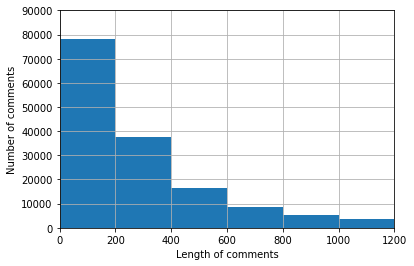

In [ ]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

Number of comments classified as malignant, highly_malignant,....etc depending on their lengths

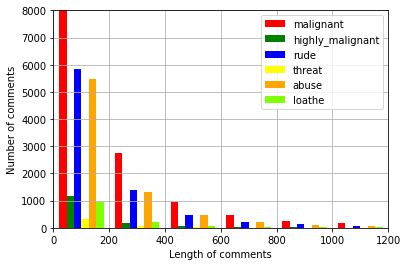

In [ ]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

## Remove excessive length comments

Some very large length comments can be seen, in our dataset. These pose serious problems like adding excessively more words to the training dataset, causing training time to increase and accuracy to decrease! Hence, a threshold of 400 characters will be created and only comments which have length smaller than 400 will be used further.

In [ ]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [ ]:
labels = np.asarray(labels)

In [ ]:
print(len(comments))

115893


Hence, after removing comments longer than 400 characters, we are still left with 115893 comments, which seems enough for training purposes.

## Preprocessing

The string library contains punctuation characters. This is imported and all numbers are appended to this string. Also, we can notice that our comment_text field contains strings such as won't, didn't, etc which contain apostrophe character('). To prevent these words from being converted to wont/didnt, the character ' represented as ' in escape sequence notation is replaced by empty character in the punctuation string.

maketrans() returns a translation table that maps each character in the punctuation_edit into the character at the same position in the outtab string i.e. it replaces every character in the removal list with a space, since outtab contains a string with spaces

In [ ]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


## Updating the list of stop words

Stop words are those words that are frequently used in both written and verbal communication and thereby do not have either a positive/negative impact on our statement.E.g. is, this, us,etc. Single letter words if existing or created due to any preprocessing step do not convey any useful meaning and hence can be directly removed. Hence letters from b to z, will be added to the list of stop words imported directly.

In [ ]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stemming and Lemmatizing

Stemming is the process of converting inflected/derived words to their word stem or the root form. Basically, a large number of similar origin words are converted to the same word.E.g. words like "stems", "stemmer", "stemming", "stemmed" as based on "stem". This helps in achieving the training process with a better accuracy. Lemmatizing is the process of grouping together the inflected forms of a word so they can be analysed as a single item. This is quite similar to stemming in its working but differs since it depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. The wordnet library in nltk will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We can now, loop once through all the comments applying :

## punctuation removal

splitting the words by space

applying stemmer and lemmatizer

recombining the words again for further processing

In [ ]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

## Applying HashVectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(alternate_sign=False)
tf = vectorizer.fit_transform(comments)
print(tf.shape)

(115893, 1048576)


## Splitting dataset into training and testing

Since the system was going out of memory using train_test_split, I had jumbled all the indexes in the beginning itself. The shuffle function defined here performs the task of assigning first 2/3rd values to train and remaining 1/3rd values to the test set.

In [ ]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(38631, 1048576)
(77262, 1048576)


## Implementation :


Let us define all the evaluation metrics

In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

Binary Relevance (BR) Method with MultinomialNB classifiers (from scratch)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# clf will be the list of the classifiers for all the 6 labels
# each classifier is fit with the training data and corresponding classifier
clf = []
for ix in range(6):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [ ]:
# predict list contains the predictions, it is transposed later to get the proper shape
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(38631, 6)


In [ ]:
# calculate results
evaluate_score(Y_test,predict)

Hamming_loss : 4.311735825287118
Accuracy : 88.19859698169864
Log_loss : 0.7879758653142859


In [ ]:
classification_report(Y_test,predict)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       1.00      0.04      0.07      4345\n           1       0.00      0.00      0.00       468\n           2       1.00      0.01      0.02      2489\n           3       0.00      0.00      0.00       139\n           4       0.00      0.00      0.00      2327\n           5       0.00      0.00      0.00       407\n\n   micro avg       1.00      0.02      0.03     10175\n   macro avg       0.33      0.01      0.01     10175\nweighted avg       0.67      0.02      0.03     10175\n samples avg       0.00      0.00      0.00     10175\n'

## BR Method with Multinomial classifier (from scikit-multilearn)

In [ ]:
pip install scikit-multilearn

In [ ]:
#create and fit classifier
from skmultilearn.problem_transform import BinaryRelevance
classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[False, True])

In [ ]:
#predictions
predictions = classifier.predict(X_test)

In [ ]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 4.311735825287118
Accuracy : 88.19859698169864
Log_loss : 0.7879758653142859


In [ ]:
classification_report(Y_test,predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       1.00      0.04      0.07      4345\n           1       0.00      0.00      0.00       468\n           2       1.00      0.01      0.02      2489\n           3       0.00      0.00      0.00       139\n           4       0.00      0.00      0.00      2327\n           5       0.00      0.00      0.00       407\n\n   micro avg       1.00      0.02      0.03     10175\n   macro avg       0.33      0.01      0.01     10175\nweighted avg       0.67      0.02      0.03     10175\n samples avg       0.00      0.00      0.00     10175\n'

## BR Method with SVM classifier (from scikit-multilearn)¶

In [ ]:
#create and fit classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=SVC(C=1.0, break_ties=False, cache_size=200,
                               class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3,
                               gamma='scale', kernel='rbf', max_iter=-1,
                               probability=False, random_state=None,
                               shrinking=True, tol=0.001, verbose=False),
                require_dense=[False, True])

In [ ]:
#predictions
predictionss = classifier.predict(X_test)

In [ ]:
#calculate scores
evaluate_score(Y_test,predictionss)

Hamming_loss : 2.164065129041443
Accuracy : 90.83378633739743
Log_loss : 1.841376393546132


In [ ]:
classification_report(Y_test,predictionss)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.95      0.62      0.75      4345\n           1       0.53      0.09      0.15       468\n           2       0.92      0.68      0.78      2489\n           3       0.78      0.05      0.09       139\n           4       0.83      0.56      0.67      2327\n           5       0.86      0.12      0.22       407\n\n   micro avg       0.90      0.57      0.70     10175\n   macro avg       0.81      0.35      0.44     10175\nweighted avg       0.89      0.57      0.68     10175\n samples avg       0.07      0.06      0.06     10175\n'

## Making all the changes as we made on our training dataset

In [ ]:
#loading the dataset
data_test=pd.read_csv('/content/drive/MyDrive/gautam bhushan/test.csv')
data_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
comment = data_test['comment_text']
print(comment.head())
comment = comment.to_numpy()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object


In [ ]:
comments = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])

In [ ]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(alternate_sign=False)
tf = vectorizer.fit_transform(comments)
print(tf.shape)

(115769, 1048576)


In [ ]:
pd.DataFrame(data=tf)

,0
0,"(0, 10919)\t0.08804509063256238\n (0, 26634..."
1,"(0, 174974)\t0.5773502691896258\n (0, 23947..."
2,"(0, 173139)\t0.4472135954999579\n (0, 27522..."
3,"(0, 103968)\t0.12309149097933272\n (0, 1232..."
4,"(0, 156674)\t0.4082482904638631\n (0, 19883..."
...,...
115764,"(0, 31813)\t0.13736056394868904\n (0, 48144..."
115765,"(0, 3856)\t0.31622776601683794\n (0, 60869)..."
115766,"(0, 7733)\t0.31622776601683794\n (0, 171262..."
115767,"(0, 26634)\t0.1386750490563073\n (0, 45419)..."


## On the basis of log loss we save Binary Relevance (BR) Method with Multinomial classifier as our final model

In [ ]:
#saving our model

import joblib
joblib.dump(classifier,'Malignant_Comments_Classifier.pkl')

['Malignant_Comments_Classifier.pkl']

In [ ]:
model=joblib.load('Malignant_Comments_Classifier.pkl')

In [ ]:
#Testing our model
import sys
nums= model.predict(tf)
np.set_printoptions(threshold=sys.maxsize)
print(nums)

  (0, 0)	1
  (38, 0)	1
  (40, 0)	1
  (45, 0)	1
  (48, 0)	1
  (56, 0)	1
  (60, 0)	1
  (64, 0)	1
  (66, 0)	1
  (72, 0)	1
  (77, 0)	1
  (85, 0)	1
  (89, 0)	1
  (94, 0)	1
  (95, 0)	1
  (97, 0)	1
  (127, 0)	1
  (131, 0)	1
  (132, 0)	1
  (135, 0)	1
  (143, 0)	1
  (147, 0)	1
  (148, 0)	1
  (154, 0)	1
  (163, 0)	1
  :	:
  (109913, 5)	1
  (110107, 5)	1
  (110181, 5)	1
  (110339, 5)	1
  (110430, 5)	1
  (110665, 5)	1
  (110864, 5)	1
  (110905, 5)	1
  (111040, 5)	1
  (111635, 5)	1
  (111967, 5)	1
  (112441, 5)	1
  (112955, 5)	1
  (113090, 5)	1
  (113445, 5)	1
  (113940, 5)	1
  (113959, 5)	1
  (114052, 5)	1
  (114291, 5)	1
  (114328, 5)	1
  (114542, 5)	1
  (114975, 5)	1
  (115188, 5)	1
  (115684, 5)	1
  (115707, 5)	1


In [ ]:
data1 = pd.DataFrame(nums) 
    
# saving the dataframe to csv
data1.to_csv('predictionss.csv')